##### На основе данных из файла user_acquisition.csv оцените, когда окупится данная рекламная кампания.

Импортируем библиотеки, которые могут пригодиться для манипуляции данными.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [ ]:
df_csv = pd.read_csv('user_acquisition.csv')

In [ ]:
df_csv.head()

,Unnamed: 0,customer_user_id,platform,media_source,campaign,install_date,cpi,visit_date,revenue
0,0,241706,android,unityads_int,HC|Android|retention|US,2020-09-14,0.958889,2020-09-22,0.034333
1,1,241143,android,unityads_int,HC|Android|retention|US,2020-09-14,0.984545,2020-09-14,0.121975
2,2,242764,android,unityads_int,HC|Android|retention|US,2020-09-15,1.002273,2020-09-16,0.177648
3,3,242947,android,unityads_int,HC|Android|retention|US,2020-09-15,1.054444,2020-09-22,0.043012
4,4,242947,android,unityads_int,HC|Android|retention|US,2020-09-15,1.054444,2020-09-24,0.045508


Предложенная выборка содержит данные о пользователях присоединившихся в течении месяца (с 2020-08-16 по 2020-01-16).

In [ ]:
{'min insall_date':df_csv['install_date'].min(),'max install_date':df_csv['install_date'].max()}

{'max install_date': '2020-09-16', 'min insall_date': '2020-08-16'}

Добавим поле ``day``, где будет посчитано, на какой день после инсталяции игры была совершена транзакция.

In [ ]:
df_csv[['visit_date','install_date']] = df_csv[['visit_date','install_date']].apply(pd.to_datetime) 
df_csv['day']=(df_csv['visit_date'] - df_csv['install_date']).dt.days+1

Построив датафрейм по одному игроку, видим, что часть информации дублируется: в каждой строке уникальны только ``visit_date``, ``revenue`` и ``day``. В то время как ``install_date`` и ``cpi`` повторяются. Следовательно имеет смысл разделить данные на два датафрейма: с данными о стоимости рекламной кампании и с данными о выручке.

In [ ]:
df_csv.loc[df_csv['customer_user_id']==241706]

,Unnamed: 0,customer_user_id,platform,media_source,campaign,install_date,cpi,visit_date,revenue,day
0,0,241706,android,unityads_int,HC|Android|retention|US,2020-09-14,0.958889,2020-09-22,0.034333,9
495,495,241706,android,unityads_int,HC|Android|retention|US,2020-09-14,0.958889,2020-09-16,0.190701,3
2264,2264,241706,android,unityads_int,HC|Android|retention|US,2020-09-14,0.958889,2020-09-21,0.114351,8
2406,2406,241706,android,unityads_int,HC|Android|retention|US,2020-09-14,0.958889,2020-09-14,0.273077,1
2687,2687,241706,android,unityads_int,HC|Android|retention|US,2020-09-14,0.958889,2020-09-17,0.352483,4
4100,4100,241706,android,unityads_int,HC|Android|retention|US,2020-09-14,0.958889,2020-09-18,0.142658,5


In [ ]:
df_rev = df_csv[['customer_user_id','revenue','day']]

Далее выясняем, что хоть у нас данные и содержат информацию о пользователях за месяц, тем не менее выгрузка состоит транзакцй за первые 15 дней с момента инсталяции по кадому пользователю.

In [ ]:
display(pd.pivot_table(df_rev, values='revenue', index=['customer_user_id'],
                    columns=['day'], aggfunc=np.sum))

day,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
customer_user_id,,,,,,,,,,,,,,,
175552,0.105317,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
175555,0.018973,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
175600,0.043757,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
175630,0.098686,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
175652,0.163873,0.033173,0.290392,0.288956,0.285476,0.109673,NaN,0.623671,0.328915,0.388565,0.696533,1.481227,0.340509,0.915405,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247842,0.048507,NaN,0.038963,NaN,NaN,NaN,NaN,NaN,0.101467,0.075950,NaN,NaN,NaN,NaN,NaN
248028,0.034170,NaN,NaN,0.002324,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
248094,0.015150,NaN,0.093614,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_cpi = df_csv[['customer_user_id','cpi']].drop_duplicates()

Посчитаем основные метрики. 
* ``MAU`` - количество уникальных пользоватейл в рассматриваемом месяце;
* ``CPI`` - средняя стоимость привлечения одного опользователя;
* ``ARPU`` - средний доход от пользователя в день
* ``PP1`` - срок окупаемости рекламной кампании, посчитанный как ``CPI``/``ARPU``

In [ ]:
MAU = df_cpi['customer_user_id'].count()
CPI = df_cpi['cpi'].sum()/MAU
ARPU = df_rev['revenue'].sum()/df_rev['day'].max()/MAU
PP1 = CPI/ARPU
print('MAU:', MAU,  sep=' ')
print('CPI:', round(CPI,3),  sep=' ')
print('ARPU:', round(ARPU,3),  sep=' ')
print('PP1:', round(PP1,2),  sep=' ')

MAU: 1052
CPI: 1.174
ARPU: 0.057
PP1: 20.72


``PP1`` несколько неточен по предложенному выше методу, так как основан на ``ARPU`` за первые 15 дней, в то время как в дальнейшем среднеденвная выручка будет снижаться. 
Более точным будет посчитать срок окупаемости ``PP2`` путем построения функции ``ARPU`` с накопительным итогом.

In [ ]:
df_cumARPU=df_rev[['day','revenue']].groupby(['day']).sum().reset_index()
df_cumARPU['revenue']=(df_cumARPU['revenue']/MAU).cumsum()

Text(0, 0.5, '$')

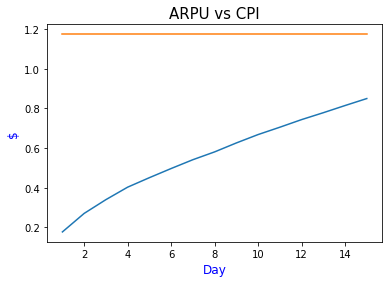

In [ ]:
plt.plot(df_cumARPU['day'],df_cumARPU['revenue'],'-',df_cumARPU['day'],[CPI for x in range(df_rev['day'].max())])
plt.title('ARPU vs CPI', fontsize=15)
plt.xlabel('Day', fontsize=12, color='blue')
plt.ylabel('$', fontsize=12, color='blue')

Т.к. за 15 дней рекламная кампания не окупилась, то нужно построить такую функцию, которая хорошо опишет текущий тренд. Методом перебора остановился на функции, представленной ниже.

In [ ]:
def func(x, A, B, C, D):
    return A*np.log((x**B)/C+D)

Совершаю поиск оптимальных параметров A, B, C и D:

In [ ]:

x=np.array(df_cumARPU['day'])
y=np.array(df_cumARPU['revenue'])

In [ ]:
u, z = curve_fit(func, x, y,  p0=(0.1, 0.1,0.1,0.1), maxfev=5000)

In [ ]:
t = np.linspace(1.0, 30, 30)

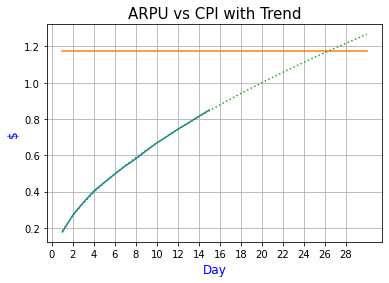

In [ ]:
plt.plot(df_cumARPU['day'],df_cumARPU['revenue'],'-',t,[CPI for x in range(30)],'-',t,func(t, *u),':')
plt.xlabel('Day', fontsize=12, color='blue')
plt.ylabel('$', fontsize=12, color='blue')
plt.xticks(np.arange(0, 30, step=2.0))
plt.title('ARPU vs CPI with Trend', fontsize=15)
plt.grid(True)

На полученном графике видно, совокупный доход с одного человека превысит затраты на его привлечение на ``26-ой день``. Это и есть срок окупаемости ``PP2``.